## Experiment Setup

In [1]:
# Import Statements / Setup
from Dataset import Dataset
import matplotlib.pyplot as plt
import numpy as np
from preprocess_data import filter_genres
import sklearn
import tensorflow as tf
import time

from models.Model import Model
from models.CNNModel import CNNModel
from models.FCModel import FCModel
from models.LogisticRegression import LogisticRegression


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def current_time_millis():
    return int(round(time.time() * 1000))

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Load / Preprocess Data

In [2]:
small_dataset = True
np.random.seed(123456789) # Make ordering of data consistent b/w runs

# List of all genres
ALL_GENRES_LIST = [
    'Action', 'Adventure', 'Animation', 'Comedy',
    'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy',
    'History', 'Horror', 'Music', 'Mystery', 'Romance',
    'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western'
]

# List of genres which we will attempt to classify.
USED_GENRES_LIST = ALL_GENRES_LIST

# Load and Shuffle Data.
start_time = current_time_millis()
posters = np.load('movie_data/posters.npy') if not small_dataset else np.load('movie_data/posters_small.npy')
genres = np.load('movie_data/genres.npy') if not small_dataset else np.load('movie_data/genres_small.npy')
posters, genres = sklearn.utils.shuffle(posters, genres)
end_time = current_time_millis()
print('Loading Data took {0} seconds\n'.format((end_time-start_time)/1000.0))

# Remove genres which we are not attempting to classify
genres = filter_genres(ALL_GENRES_LIST, USED_GENRES_LIST, genres)
label_probabilities = np.mean(genres, axis=0, keepdims=True)
print('Fraction of examples which belong to genre:')
for i, genre in enumerate(USED_GENRES_LIST):
    print('{0} : {1:.2f}'.format(genre, label_probabilities[0][i]))

Loading Data took 1.449 seconds

Fraction of examples which belong to genre:
Action : 0.11
Adventure : 0.08
Animation : 0.10
Comedy : 0.26
Crime : 0.11
Documentary : 0.14
Drama : 0.54
Family : 0.06
Fantasy : 0.06
History : 0.06
Horror : 0.03
Music : 0.06
Mystery : 0.06
Romance : 0.14
Science Fiction : 0.05
TV Movie : 0.02
Thriller : 0.11
War : 0.05
Western : 0.02


## Initializing Train / Validation / Test Datasets

In [3]:
# TRAIN/VALID/TEST SPLIT = 75/15/10
SPLITS = [0.75, 0.15, 0.10]
NORMALIZE = False

datasets = Dataset.build_dataset_splits(
    posters,
    genres,
    SPLITS,
    NORMALIZE
)

print('Total Number of Examples: {0}'.format(len(posters)))
print('Number of Train/Valid/Test Examples: {0}/{1}/{2}'.format(
    datasets['train'].size(),
    datasets['valid'].size(),
    datasets['test'].size()
))
print('Image Size: {0}'.format(posters.shape[1:]))
print('Number of Genres: {0}'.format(genres.shape[1]))

Total Number of Examples: 5000
Number of Train/Valid/Test Examples: 3750/750/500
Image Size: (278, 185, 3)
Number of Genres: 19


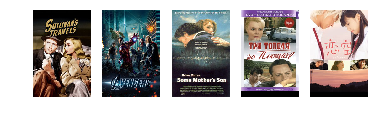

In [4]:
rows, columns = 1, 5
fig = plt.figure()
for i in range(1, rows*columns+1):
    fig.add_subplot(rows, columns, i)
    image = datasets['train'].X[i-1]
    plt.imshow(image.astype(np.uint8))
    plt.axis('off')

## Baseline Model (Logistic Regression)

In [7]:
# Free up memory from previous run(s)
if 'model' in vars() or 'model' in globals():
    del model
    tf.reset_default_graph()

model = LogisticRegression(
    USED_GENRES_LIST,
    label_probabilities,
    datasets['train'].X.shape[1:]
)

model.train(
    datasets['train'],
    datasets['valid'],
    num_epochs = 10,
    batch_size = 100,
    verbose=True
)

Initializing model...Done.
Training Model...
Epoch #1 out of 10: 
38/38 [==============================] - 5s - Train Loss: 23.4361     
Validation Loss: 23.0990 *
------------------------------------------------------------
|      Genre      | Accuracy | Precision | Recall |   F1   |
------------------------------------------------------------
| Action          |  0.4920  |   0.0919  | 0.4304 | 0.1514 |
| Adventure       |  0.2307  |   0.0735  | 0.8182 | 0.1349 |
| Animation       |  0.8880  |   0.1818  | 0.0260 | 0.0455 |
| Comedy          |  0.3813  |   0.2771  | 0.8426 | 0.4171 |
| Crime           |  0.7307  |   0.1037  | 0.1474 | 0.1217 |
| Documentary     |  0.8427  |   0.0588  | 0.0097 | 0.0167 |
| Drama           |  0.5200  |   0.5312  | 0.8881 | 0.6648 |
| Family          |  0.6560  |   0.0583  | 0.3043 | 0.0979 |
| Fantasy         |  0.4267  |   0.0592  | 0.6047 | 0.1079 |
| History         |  0.5733  |   0.0415  | 0.3939 | 0.0751 |
| Horror          |  0.2133  |   0.0380  | 

KeyboardInterrupt: 

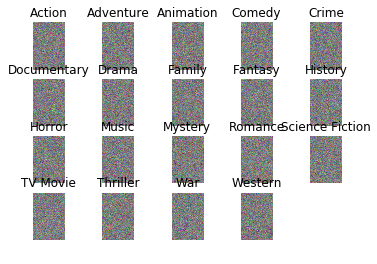

In [8]:
W = model.get_weights()
W = np.reshape(W, (278, 185, 3, len(USED_GENRES_LIST)))

W_min, W_max = np.min(W), np.max(W)
for i in range(len(USED_GENRES_LIST)):
    plt.subplot(4, 5, i + 1)
    # Rescale the weights to be between 0 and 255
    W_img = 255.0 * (W[:, :, :, i].squeeze() - W_min) / (W_max - W_min)
    plt.imshow(W_img.astype('uint8'))
    plt.axis('off')
    plt.title(USED_GENRES_LIST[i])

## CNN Model

In [ ]:
# Free up memory from previous run(s)
if 'model' in vars() or 'model' in globals():
    del model
    tf.reset_default_graph()

model = CNNModel(
    USED_GENRES_LIST,
    label_probabilities,
    posters.shape[1:],
    filter_counts = [32, 32],
    unit_counts = [100],
    resize_shape = (32, 32)
)

model.train(
    datasets['train'],
    datasets['valid'],
    num_epochs = 10,
    batch_size = 100,
    eta = 1e-4,
    augmentation = False,
    saving = False,
    verbose = True,
)

Initializing model...Done.
Training Model...
Epoch #1 out of 10: 


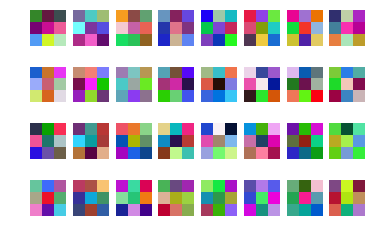

In [39]:
graph = tf.get_default_graph()

#for n in graph.as_graph_def().node:
#    print(n.name)

W = graph.get_tensor_by_name('conv2d/kernel:0').eval(session=model.session)

W_min, W_max = np.min(W), np.max(W)
for i in range(W.shape[-1]):
    plt.subplot(4, 8, i + 1)
    # Rescale the weights to be between 0 and 255
    W_img = 255.0 * (W[:, :, :, i].squeeze() - W_min) / (W_max - W_min)
    plt.imshow(W_img.astype('uint8'))
    plt.axis('off')


## Transfer Learning Model

In [ ]:
import keras
model_name = 'InceptionV3'

if model_name == 'VGG16':
    from keras.applications.vgg16 import VGG16
    pretrained_model = VGG16(weights='imagenet', include_top=False)
    preprocess_fn = keras.applications.vgg16.preprocess_input

elif model_name == 'VGG19':
    from keras.applications.vgg19 import VGG19
    pretrained_model = VGG19(weights='imagenet', include_top=False)
    preprocess_fn = keras.applications.vgg19.preprocess_input

elif model_name == 'InceptionV3':
    from keras.applications.inception_v3 import InceptionV3
    pretrained_model = InceptionV3(weights='imagenet', include_top=False)
    preprocess_fn = keras.applications.inception_v3.preprocess_input

elif model_name == 'ResNet50':
    from keras.applications.resnet50 import ResNet50
    pretrained_model = ResNet50(weights='imagenet', include_top=False)
    preprocess_fn = keras.applications.resnet50.preprocess_input

else:
    print('INVALID MODEL NAME: {0}'.format(model_name))


def build_feature_datasets(datasets, pretrained_model, preprocess_fn):
    new_datasets = {}
    for dataset_name in ['train', 'valid', 'test']:
        newX = pretrained_model.predict(preprocess_fn(datasets[dataset_name].X))
        new_datasets[dataset_name] = Dataset(
            newX,
            datasets[dataset_name].y,
            mean = np.zeros_like(newX[0]),
            std = np.ones_like(newX[0]),
        )
        print('{0}: {1}'.format(dataset_name, newX.shape))

feature_datasets = build_feature_datasets(datasets, pretrained_model, preprocess_fn)

87916544/87910968 [==============================] - 11s 0us/step


In [10]:
# Free up memory from previous run(s)
if 'model' in vars() or 'model' in globals():
    del model
    tf.reset_default_graph()

model = FCModel(
    USED_GENRES_LIST,
    label_probabilities,
    feature_datasets['train'].X.shape[1:],
    hidden_layer_sizes = [32]
)

model.train(
    feature_datasets['train'],
    feature_datasets['valid'],
    num_epochs = 10,
    batch_size = 100,
    eta = 1e-4,
    saving = False,
    verbose = False,
)

Initializing model...Done.
Training Model...
Epoch #1 out of 10: 
222/222 [==============================] - 5s - Train Loss: 1.3013     
Validation Loss: 1.3917 *
Epoch #2 out of 10: 
222/222 [==============================] - 5s - Train Loss: 0.9519     
Validation Loss: 1.3809 *
Epoch #3 out of 10: 
222/222 [==============================] - 5s - Train Loss: 0.8724     
Validation Loss: 1.4087 
Epoch #4 out of 10: 
222/222 [==============================] - 6s - Train Loss: 0.8410     
Validation Loss: 1.4105 
Epoch #5 out of 10: 
 45/222 [=====>........................] - ETA: 12s - Train Loss: 0.8295

KeyboardInterrupt: 